# How can machine learning be applied to predict site viability scores for offshore basins?

In my second subquestion, I use a new dataset of potential offshore injection sites across the Gulf of Mexico from Wendt et al. (2022). 

# Import Necessary Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from plotnine import *
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, RidgeCV
from sklearn.model_selection import cross_val_score, train_test_split, KFold,GridSearchCV
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from matplotlib import cm

# Read in Data from Wendt et al. (2022)

First, I read in the data.

In [2]:
wendt = pd.read_csv('wendt_data.csv', skiprows=3)
wendt

,Grid FID,Grid ID,Longitude\n(degrees),Latitude\n(degrees),CO2 Source ID (tied to NATCARB dataset)*,Distance (km),CO2 Source ID (tied to NATCARB dataset),Distance (km).1,CO2 Source ID (tied to NATCARB dataset).1,Distance (km).2,...,Sum of Reservoir Quality W/O Depth (feet),New Injectivity,S1,S2,S3,S4,S1.1,S2.1,S3.1,S4.1
0,0,36663,-96.964053,26.000342,1671,56.265652,860,39.710421,286,127.205047,...,9.1271,12.3958,57.746243,NaN,38.572100,NaN,25-50%,NaN,25-50%,NaN
1,1,36668,-97.035537,26.071826,1671,50.940346,860,34.179635,286,117.880692,...,1.5259,1.7557,30.571945,NaN,16.120983,NaN,0-25%,NaN,0-25%,NaN
2,2,36669,-96.964053,26.071826,1671,57.783507,860,41.034622,286,124.718795,...,9.1271,12.3958,57.670181,NaN,38.559063,NaN,25-50%,NaN,25-50%,NaN
3,3,36670,-97.035537,26.143310,1671,53.574517,860,37.428918,286,115.740856,...,9.1271,12.3958,32.312887,NaN,14.222778,NaN,0-25%,NaN,0-25%,NaN
4,4,36671,-96.964053,26.143310,1671,60.118581,860,43.774470,286,122.694148,...,9.1271,12.3958,57.596115,NaN,38.506005,NaN,25-50%,NaN,25-50%,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2554,2554,60802,-87.742585,29.717522,1205,90.932440,520,76.494158,1533,86.555143,...,9.9857,11.2027,30.814319,NaN,16.993804,NaN,0-25%,NaN,0-25%,NaN
2555,2555,60808,-87.742585,29.789007,1205,84.443641,520,68.570209,1533,79.735503,...,6.8179,5.9596,30.510465,NaN,15.706714,NaN,0-25%,NaN,0-25%,NaN
2556,2556,60864,-88.314459,30.217912,1497,27.789683,2459,17.932734,576,23.083298,...,3.0173,8.4316,53.280620,NaN,33.239677,NaN,25-50%,NaN,0-25%,NaN
2557,2557,60865,-88.242975,30.217912,1497,34.138032,3674,15.290775,576,20.378109,...,10.4977,13.0178,53.660471,NaN,34.577485,NaN,25-50%,NaN,0-25%,NaN


The data contains 2559 rows describing gridded pixel locaitons across the Gulf of Mexico and 68 features related to each location.

In [3]:
wendt.columns

Index(['Grid FID', 'Grid ID', 'Longitude\n(degrees)', 'Latitude\n(degrees)',
       'CO2 Source ID (tied to NATCARB dataset)*', 'Distance (km)',
       'CO2 Source ID (tied to NATCARB dataset)', 'Distance (km).1',
       'CO2 Source ID (tied to NATCARB dataset).1', 'Distance (km).2',
       'Caisson Platform', 'Fixed Platform', 'Well Protector Platform',
       'Pipeline', 'Fault', 'Salt dome', 'Shipping Route (w/5 MI Buffer)',
       'Shipping Route (w/10 mi Buffer)', 'Fault.1', 'Active Wells',
       'P&A Wells', 'Caisson Platform.1', 'Major Platform',
       'Well Protector Platform.1', 'Pipeline.1', 'Salt dome.1', 'EOR Wells',
       'Shipping Route (w/10 mi Buffer).1', 'Number of plays',
       '(SUM) Injectivity W Depth - (kh)',
       '(SUM) Quality W/O Depth - ([h x E]/[1,000 feet to reservoir bottom])',
       'Capacity per Grid - (million tonnes)', 'Water Depth - (feet)',
       'Average Calculated Water Depth - (feet)',
       '(SUM) Hydrocarbon Potential W/O Depth - ([h x S

# Data Cleaning
## Drop Columns
First, I drop columns in the dataset that contain irrelevant information or logistical information that should not be used when applying machine learning techniques. I drop grid identifier information such as **Grid ID** and **Grid FID**. I also drop **CO2 Source ID (tied to NATCARB dataset)** columns because they contain ID location information and would hinder models in areas with vastly different ID information. I also drop the **Longitude\n(degrees)** and **Latitude\n(degrees)** columns for the same concern of reproducibility. Ideally, machine learning techniques will rely on site features opposed to geospatial locations or codes for modeling and applications. 

In [4]:
wendt = wendt.drop(
    columns = ['Grid ID', 'Grid FID', 'CO2 Source ID (tied to NATCARB dataset)*', 
               'CO2 Source ID (tied to NATCARB dataset)', 'CO2 Source ID (tied to NATCARB dataset).1',
              "Longitude\n(degrees)", "Latitude\n(degrees)"])

## Assess Missing Data
Next, I evaluate potential missing data. 

In [5]:
for column in wendt.columns:
    print(sum(wendt[column].isna()))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2233
0
2233
0
2233
0
2233


The only columns with missing data are the site scores and their respective quartiles for Wendt's Scenario 2 and Scenario 4. Since my analysis is centered around Scenarios 1 and 3, there is no relevant missing data. Next, I drop the columns with missing data both because they are missing substantial data and because the scenarios are not relevant.

In [6]:
wendt = wendt.drop(
    columns = ['S2', 'S4', 'S2.1', 'S4.1'])

## Modify Data Type

The last 2 columns contain quartile information for the site score, which is currently stored as a string. I modify the data types to floats (0.25, 0.5, 0.75, 1) to represent the quartile bin.

In [7]:
wendt.iloc[:, -1]

0        25-50%
1         0-25%
2        25-50%
3         0-25%
4        25-50%
         ...   
2554      0-25%
2555      0-25%
2556      0-25%
2557      0-25%
2558    75-100%
Name: S3.1, Length: 2559, dtype: object

To replace the column with float values, I extract the last digit in the bin using regular expressions. I store this as **viability_score1_quartile**. I also merge this back to the original dataframe. I do this for both Scenario 1 and Scenario 3 data.

In [8]:
viability_score1_quartile = wendt['S1.1'].str.extract(f'(\d+)%').astype(int)
viability_score1_quartile.columns = ['Viability_score1_quartile']

viability_score3_quartile = wendt['S3.1'].str.extract(f'(\d+)%').astype(int)
viability_score3_quartile.columns = ['Viability_score3_quartile']

In [9]:
wendt = wendt.merge(viability_score1_quartile, left_index=True, right_index=True)
wendt = wendt.merge(viability_score3_quartile, left_index=True, right_index=True)

Finally, I drop **S1.1** and **S3.1**.

In [10]:
wendt= wendt.drop(columns = ['S1.1', 'S3.1'])

# Principal Component Analysis 

Principal Component Analysis (PCA) is a method of unsupervised machine learning which maximizes variance and important information from a table by creating principal components of a linear combination of features. This is typically performed on inter-correlated data with linearly dependent features. 

I perform PCA using the data's features and withhold data labels (site score information). This enables the model to reveal inherent structures within the data to potentially partition the sites based on certain characteristics without explicit training. I undertake this for both Scenario 1 and Scenario 3, which center around site feasibility and technological constraints.

In order to perform PCA, I need to reorient the data to be a 2559 x 58 numpy array. I also only want to include the data, not the site scores and quartiles for a given scenario. I create **wendt_pca_arr** which is a numpy array of the wendt dataframe only containing feature information, not scores.

In [11]:
wendt.iloc[:, -4:]

,S1,S3,Viability_score1_quartile,Viability_score3_quartile
0,57.746243,38.572100,50,50
1,30.571945,16.120983,25,25
2,57.670181,38.559063,50,50
3,32.312887,14.222778,25,25
4,57.596115,38.506005,50,50
...,...,...,...,...
2554,30.814319,16.993804,25,25
2555,30.510465,15.706714,25,25
2556,53.280620,33.239677,50,25
2557,53.660471,34.577485,50,25


In [12]:
wendt_pca = wendt.iloc[:, :-4]
wendt_pca_arr = wendt_pca.to_numpy()
wendt_pca_arr.shape

(2559, 53)

Next, I calculate the mean and standard deviation across each column/feature in order to center and standardize the numpy array. This is essential in PCA because it prevents percieved feature importance due to size of numbers alone. This way, features are standardized across different scales, allowing PCA to identify key features not considering conflated number values.

In [25]:
wendt_mean = np.mean(wendt_pca_arr, axis=0)
wendt_std = np.std(wendt_pca_arr, axis=0)
wendt_standardized = (wendt_pca_arr - wendt_mean) / wendt_std

PCA is an application of Singular Value Decomposition (SVD), so I perform SVD and save the resulting matrices. SVD does [], which will then be used to [].

In [26]:
u, s, vt = np.linalg.svd(wendt_standardized, full_matrices=False)
print(f"Dimensions of U: {u.shape}")
print(f"1D List of diagonal elements of Sigma: {s}")
print(f"Dimensions of V Transpose: {vt.shape}")

Dimensions of U: (2559, 53)
1D List of diagonal elements of Sigma: [1.76174660e+02 1.39645357e+02 1.29553427e+02 9.05843784e+01
 8.43948289e+01 7.94977672e+01 7.59221181e+01 7.40480925e+01
 7.17396549e+01 6.58050162e+01 6.38492231e+01 5.77124185e+01
 5.12836608e+01 4.99723475e+01 4.76424052e+01 4.38758685e+01
 3.71639483e+01 3.56835643e+01 3.40692303e+01 3.19870406e+01
 3.04454602e+01 2.88664217e+01 2.20055840e+01 2.14174960e+01
 2.03494696e+01 1.58534847e+01 1.55600222e+01 1.51576714e+01
 1.44425173e+01 1.16962216e+01 9.60208667e+00 8.17278238e+00
 4.42255638e+00 3.92078736e-01 1.50004338e-04 1.13882284e-04
 7.89610981e-05 7.56524562e-05 7.07212323e-05 6.73746285e-05
 4.99014285e-05 4.76425142e-05 4.37160056e-05 3.33820932e-05
 1.92888525e-05 1.24966321e-14 1.16334167e-14 1.16334167e-14
 1.16334167e-14 1.16334167e-14 1.16334167e-14 1.16334167e-14
 1.16334167e-14]
Dimensions of V Transpose: (53, 53)


**u** is []. **s** is []. **vt** describes [].

Here, we confirm that the sum of the feature variances of the new matrix u is the same as the sum of the variance from the original, standardized matrix.

In [27]:
wendt_total_variance = (sum(s**2))/u.shape[0]

print("wendt_total_variance: {:.3f} should approximately equal the sum of the feature variances: {:.3f}"
      .format(wendt_total_variance, np.sum(np.var(wendt_standardized, axis=0))))

wendt_total_variance: 53.000 should approximately equal the sum of the feature variances: 53.000


Next, we matrix multiply **wendt_standardized** by **vt**, which [does this]. The [first two columns in this matrix are the first two principal components, ordered by maximum variance].

In [28]:
wendt_2d = wendt_standardized @ vt.transpose()[:, :2]
wendt_2d.shape

(2559, 2)

In [29]:
pca = PCA()
pca.fit(wendt_standardized)
wendt_2d= pca.transform(wendt_standardized)[:, :2]

## Visualize Principal Components
In order to visualize the PCA, I plot the transformed data using the first two principal components as the x and y axis.
### Principal Component Figure using Quartile Bins
I create **score_category** using **viability_score_quartile** by extracting the first column. This is the quartile bin representing the site evaluation score. I color the data based on their score quartile classification **score_category**.

In [17]:
score_category_s3 = wendt['Viability_score3_quartile'].map(
    {25: '1st', 50: '2nd', 75:'3rd', 100:'4th'})
score_category_s3.shape

(2559,)

In [18]:
score_category_s1 = wendt['Viability_score1_quartile'].map(
    {25: '1st', 50: '2nd', 75:'3rd', 100: '4th'})
score_category_s1.shape

(2559,)

#### Scenario 3 PCA

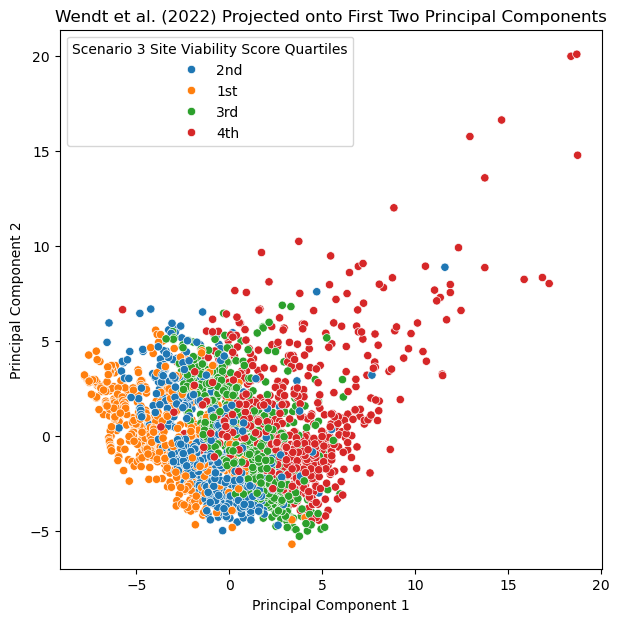

In [19]:
plt.figure(figsize = (7, 7))
plt.title("Wendt et al. (2022) Projected onto First Two Principal Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
ax = sns.scatterplot(x = wendt_2d[:, 0], y = wendt_2d[:, 1], hue = score_category_s3)
ax.legend(title='Scenario 3 Site Viability Score Quartiles');

Here, we can visualize the differences in space between lower and higher scoring sites, demonstrating that PCA is largely successful in separating different sites without these specific labels. Moving from right to left, sites score higher and higher, with the highest scoring sites on the far left. Although most sites are clumped together, many high scoring sites trail towards the top left, indicating an potential area of further analysis.

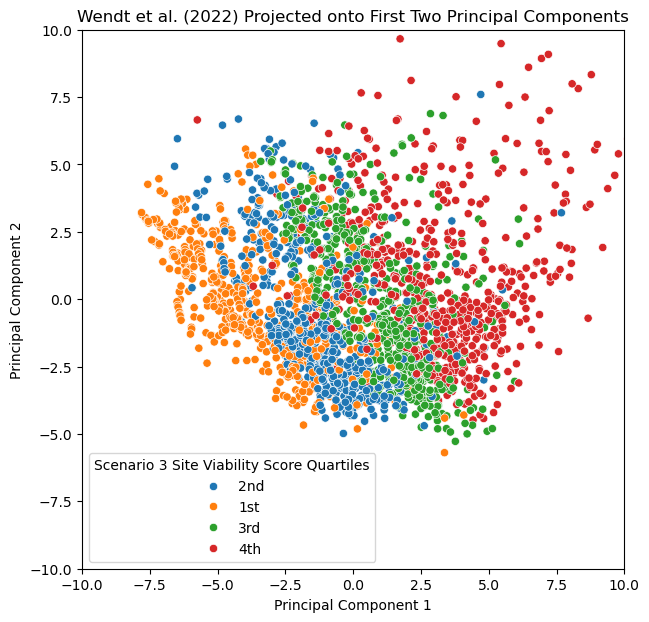

In [46]:
plt.figure(figsize = (7, 7))
plt.title("Wendt et al. (2022) Projected onto First Two Principal Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
ax = sns.scatterplot(x = wendt_2d[:, 0], y = wendt_2d[:, 1], hue = score_category_s3)
ax.legend(title='Scenario 3 Site Viability Score Quartiles');
plt.xlim(-10, 10)
plt.ylim(-10, 10);

After focusing in on the majority of the data, we can better identify trends of increasing site scores throughout space. Although there is no complete separation between clases, one can clearly see the fluidity of scores from left to right. There is also a much more defined distinction between the highest and lowest scores (far left and far right).

#### Scenario 1 PCA

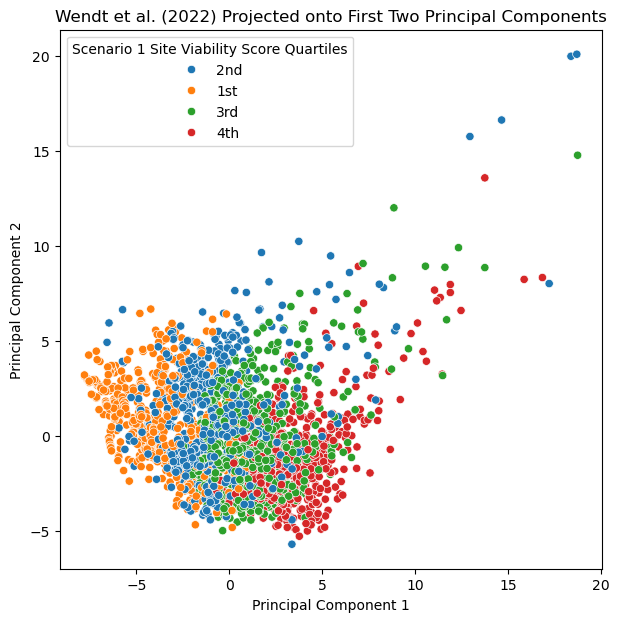

In [47]:
plt.figure(figsize = (7, 7))
plt.title("Wendt et al. (2022) Projected onto First Two Principal Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
ax = sns.scatterplot(x = wendt_2d[:, 0], y = wendt_2d[:, 1], hue = score_category_s1)
ax.legend(title='Scenario 1 Site Viability Score Quartiles');

Here, I plot the same data but color it based on the site score quartiles for scenario 1. We see a similar trend of Principal Component 1 being negatively correlated with site score. However within this visual, Principal Component 2 is positively correlated with site score. Additionally, data with large Principal Component 2 values range more in site score compared to with Scenario 3.
### Principal Component Figure using Site Score
Next, I plot the same data, however I color based on site score itself and not the quartile classification.
#### Scenario 3 PCA

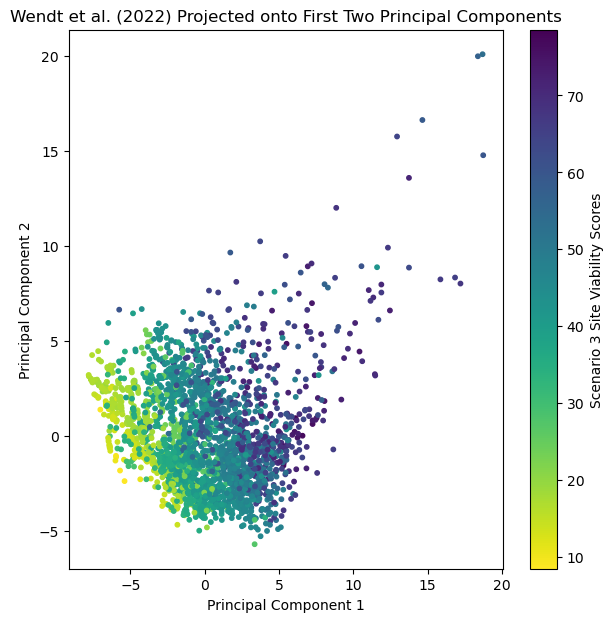

In [48]:
plt.figure(figsize = (7, 7))
plt.title("Wendt et al. (2022) Projected onto First Two Principal Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
sc = plt.scatter(x = wendt_2d[:, 0], y = wendt_2d[:, 1], c = wendt['S3'], s= 10, cmap='viridis_r')
cbar = plt.colorbar(sc)
cbar.set_label("Scenario 3 Site Viability Scores");

#### Scenario 1 PCA

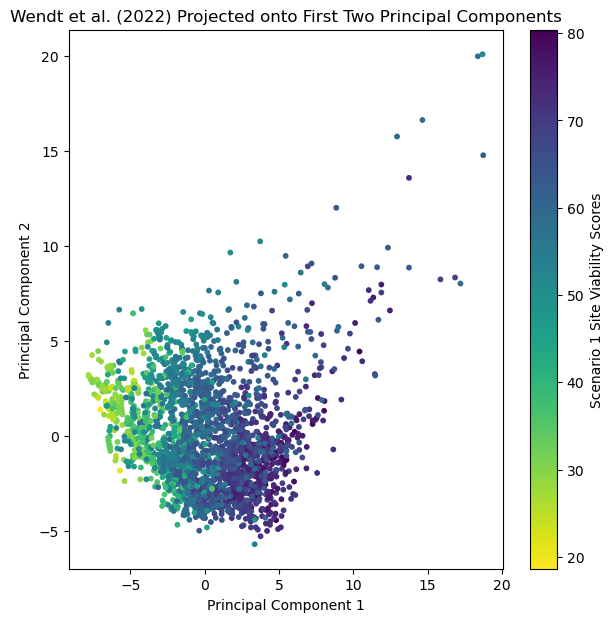

In [49]:
plt.figure(figsize = (7, 7))
plt.title("Wendt et al. (2022) Projected onto First Two Principal Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
sc = plt.scatter(x = wendt_2d[:, 0], y = wendt_2d[:, 1], c = wendt['S1'], s= 10, cmap='viridis_r')
cbar = plt.colorbar(sc)
cbar.set_label("Scenario 1 Site Viability Scores");

Similarly with the coloring based on quartiles, we can visualize the spatial distinction between higher and lower site scores. This is especially identifiable with Scenario 3.

## PCA Analysis
To further determine the success of the PCA, I calculate the percent of total dataset variance captured by the first two principal components.

In [30]:
wendt_2d_variance = sum(np.var(wendt_2d, axis=0))/wendt_total_variance
wendt_2d_variance

0.3726274018012859

Only 37% of variance is captured using the first two principal components, demonstrating large variance loss.
## Scree Plot
Next, I create a Scree Plot to visualize the weight of each principal component.

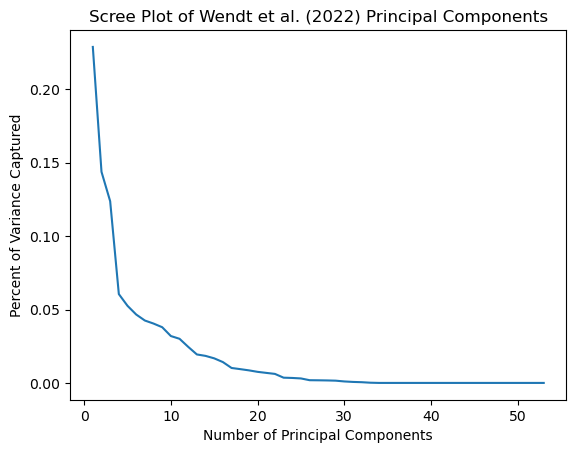

In [31]:
x= np.arange(1, 54)
y= s**2/len(wendt_pca_arr)/ wendt_total_variance
plt.plot(x, y)
plt.xlabel('Number of Principal Components')
plt.ylabel('Percent of Variance Captured')
plt.title('Scree Plot of Wendt et al. (2022) Principal Components') ;

Here, we can better vidualize the weighting of all principal components. It is clear that the first few principal components contribute to a majority of data variance. While 37% of total variance captured does not seem particularly high, when looking at all PC weighting, we can see that the first few are particularly beneficial.

Overall, this principal component analysis demonstrates high applications of unsupervised machine learning for CGS site valuation.

# Site Score Prediction Modeling
## Define Visualization Functions 

In [52]:
def feature_importance_plot(model, X_train):
    # Extract feature importance from the trained Random Forest model
    importances = model.feature_importances_
    feature_names = X_train.columns 

    # Create a DataFrame for visualization
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 10))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.title('Feature Importance from Random Forest')
    plt.gca().invert_yaxis()  # To show the highest importance feature at the top
    plt.show()

In [32]:
def plot_residuals(y_test, y_pred, model_name):
    residuals = y_test - y_pred
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, color='blue', alpha=0.7)
    plt.axhline(y=0, color='red', linestyle='--')  # Line at y=0
    plt.xlabel('Predicted Values (y_pred)')
    plt.ylabel('Residuals (y_test - y_pred)')
    plt.title(f'{model_name} Residual Plot')
    plt.show()

In [33]:
wendt.iloc[:, :-4]

,Distance (km),Distance (km).1,Distance (km).2,Caisson Platform,Fixed Platform,Well Protector Platform,Pipeline,Fault,Salt dome,Shipping Route (w/5 MI Buffer),...,Subsea depth - Saline Reservoirs,Water depth - Saline Reservoirs,Subsea depth - Oil Reservoirs,Water depth - Oil Reservoirs,Above salt domes,Active Well Density,P&A Well Density,Faults,Sum of Reservoir Quality W/O Depth (feet),New Injectivity
0,56.265652,39.710421,127.205047,0,0,0,1,0,0,1,...,64.7705,64.8147,64.7705,64.8147,0.0,99.1011,98.3193,100.0,9.1271,12.3958
1,50.940346,34.179635,117.880692,0,0,0,0,0,0,1,...,67.0898,51.1750,67.0898,51.1750,0.0,100.0000,100.0000,100.0,1.5259,1.7557
2,57.783507,41.034622,124.718795,0,0,0,1,0,0,1,...,64.7705,64.8147,64.7705,64.8147,0.0,99.7753,99.5798,100.0,9.1271,12.3958
3,53.574517,37.428918,115.740856,0,0,0,0,1,0,1,...,64.7705,64.8147,64.7705,64.8147,0.0,100.0000,100.0000,0.0,9.1271,12.3958
4,60.118581,43.774470,122.694148,0,0,0,1,0,0,1,...,64.7705,64.8147,64.7705,64.8147,0.0,100.0000,100.0000,100.0,9.1271,12.3958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2554,90.932440,76.494158,86.555143,0,0,0,0,0,0,1,...,77.9115,47.2829,77.9115,47.2829,0.0,100.0000,100.0000,100.0,9.9857,11.2027
2555,84.443641,68.570209,79.735503,0,0,0,0,0,0,1,...,74.1428,51.4014,74.1428,51.4014,0.0,100.0000,100.0000,100.0,6.8179,5.9596
2556,27.789683,17.932734,23.083298,0,0,0,1,0,0,1,...,98.1641,68.9916,98.1641,68.9916,0.0,100.0000,100.0000,100.0,3.0173,8.4316
2557,34.138032,15.290775,20.378109,0,0,0,1,0,0,1,...,76.2837,64.5917,76.2837,64.5917,0.0,100.0000,100.0000,100.0,10.4977,13.0178


First, I create a 70/30 train test split on **wendt**. 

In [34]:
#define X (all data except for site score information)
X = wendt.iloc[:, :-4]
#define y for scenario 3 and scenario 1
y_s3 = wendt['S3']
y_s1 = wendt['S1']

In [35]:
X_train_s3, X_test_s3, y_train_s3, y_test_s3 = train_test_split(
    X, y_s3, test_size=0.3, random_state =22) #scenario 3
X_train_s1, X_test_s1, y_train_s1, y_test_s1 = train_test_split(
    X, y_s1, test_size=0.3, random_state=22) #scenario 1

In [58]:
cv = KFold(n_splits=5, shuffle=True, random_state=22)

## Random Forest Regressor

In [36]:
#without hyperparameter tuning
rf_s1 = RandomForestRegressor(random_state=22)
rf_s1.fit(X_train_s1, y_train_s1)
y_pred_rf_s1= rf_s1.predict(X_test_s1)
print('MSE: ', mean_squared_error(y_test_s1, y_pred_rf_s1))

MSE:  1.9162087203146108


1.916

In [43]:
cv = KFold(n_splits=5, shuffle=True, random_state=22)
hyperparameters = {
    'n_estimators': [200, 400],
    'max_depth': [None, 20],
    'min_samples_leaf': [1, 3],
    'max_features': ['sqrt', 0.5]}

rf_s1= GridSearchCV(
    estimator = RandomForestRegressor(random_state=22),
    param_grid = hyperparameters,
    scoring= {'mse': 'neg_mean_squared_error', 'r2': 'r2'},
    refit='mse', 
    cv=cv,
    return_train_score= True)
rf_s1.fit(X_train_s1, y_train_s1)
test_preds_rf_s1 = rf_s1.predict(X_test_s1)
train_preds_rf_s1 = rf_s1.predict(X_train_s1)
    
print('Train MSE: ', mean_squared_error(y_train_s1, train_preds_rf_s1) )
print('Mean Validation MSE: ', -rf_s1.cv_results_['mean_test_mse'][rf_s1.best_index_] )
print('Test MSE: ', mean_squared_error(y_test_s1, test_preds_rf_s1))
print('Train R2: ', r2_score(y_train_s1, train_preds_rf_s1) )
print('Mean Validation R2: ', rf_s1.cv_results_['mean_test_r2'][rf_s1.best_index_] )
print('Test R2: ', r2_score(y_test_s1, test_preds_rf_s1) )

,estimator,RandomForestR...ndom_state=22)
,param_grid,"{'max_depth': [None, 20], 'max_features': ['sqrt', 0.5], 'min_samples_leaf': [1, 3], 'n_estimators': [200, 400]}"
,scoring,"{'mse': 'neg_mean_squared_error', 'r2': 'r2'}"
,n_jobs,None
,refit,'mse'
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_estimators,400


Train MSE:  0.21534001675942735
Mean Validation MSE:  1.8082453593974361
Test MSE:  1.5526846028930568
Train R2:  0.9987954153055841
Mean Validation R2:  0.9898349888137108
Test R2:  0.9913105331078859


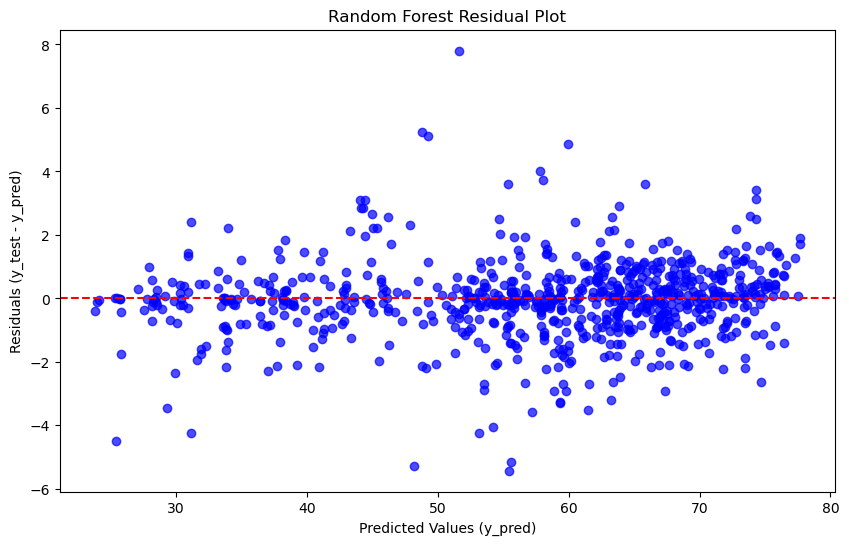

In [46]:
plot_residuals(y_test_s1, test_preds_rf_s1, 'Scenario 1 Random Forest Regressor')

cv = KFold(n_splits=5, shuffle=True, random_state=22)

def model(model_name, model, hyperparameters, X_train, y_train, X_test, y_test):
    model_name = GridSearchCV(
        estimator = model(random_state=22),
        param_grid = hyperparameters,
        scoring={'mse': 'neg_mean_squared_error', 'r2': 'r2'},
        refit='mse', 
        cv=cv,
        return_train_score=True)
    model_name.fit(X_train, y_train)
    
    test_preds = model_name.predict(X_test)
    train_preds = model_name.predict(X_train)
    
    print('Train MSE: ', mean_squared_error(y_train, train_preds) )
    print('Mean Validation MSE: ', -model_name.cv_results_['mean_test_mse'][model_name.best_index_] )
    print('Test MSE: ', mean_squared_error(y_test, test_preds))
    print('Train R2: ', r2_score(y_train, train_preds) )
    print('Mean Validation R2: ', model_name.cv_results_['mean_test_r2'][model_name.best_index_] )
    print('Test R2: ', r2_score(y_test, test_preds) )
    return test_preds

OKAY MODIFY R2 SO ITS MORE INTERPRETABLE AND THEN I STILL NEED TWO FUNCTIONS BC I NEED TO PLOT RESIDUALS

def evaluate(model_name, test_preds, train_preds, X_train, y_train, y_test):
    test_preds = model_name.predict(X_test)
    train_preds = model_name.predict(X_train)
    
    print('Train MSE: ', mean_squared_error(y_train, train_preds) )
    print('Mean Validation MSE: ', -model_name.cv_results_['mean_test_mse'][model_name.best_index_] )
    print('Test MSE: ', mean_squared_error(y_test, test_preds))
    print('Train R2: ', r2_score(y_train, train_preds) )
    print('Mean Validation R2: ', -model_name.cv_results_['mean_test_mse'][model_name.best_index_] )
    print('Test R2: ', r2_score(y_test, test_preds) )

In [64]:
rf_s3 = RandomForestRegressor(random_state =22)
rf_s3.fit(X_train_s3, y_train_s3)
y_pred_rf_s3= rf_s3.predict(X_test_s3)
print('MSE: ', mean_squared_error(y_test_s3, y_pred_rf_s3))

MSE:  0.8203440163690715


In [47]:
cv = KFold(n_splits=5, shuffle=True, random_state=22)
hyperparameters = {
    'n_estimators': [200, 400],
    'max_depth': [None, 20],
    'min_samples_leaf': [1, 3],
    'max_features': ['sqrt', 0.5]}

rf_s3= GridSearchCV(
    estimator = RandomForestRegressor(random_state=22),
    param_grid = hyperparameters,
    scoring= {'mse': 'neg_mean_squared_error', 'r2': 'r2'},
    refit='mse', 
    cv=cv,
    return_train_score= True)
rf_s3.fit(X_train_s3, y_train_s3)
test_preds_rf_s3 = rf_s3.predict(X_test_s3)
train_preds_rf_s3 = rf_s3.predict(X_train_s3)
    
print('Train MSE: ', mean_squared_error(y_train_s3, train_preds_rf_s3) )
print('Mean Validation MSE: ', -rf_s3.cv_results_['mean_test_mse'][rf_s3.best_index_] )
print('Test MSE: ', mean_squared_error(y_test_s3, test_preds_rf_s3))
print('Train R2: ', r2_score(y_train_s3, train_preds_rf_s3) )
print('Mean Validation R2: ', rf_s3.cv_results_['mean_test_r2'][rf_s3.best_index_] )
print('Test R2: ', r2_score(y_test_s3, test_preds_rf_s3) )

Train MSE:  0.09988920125833063
Mean Validation MSE:  0.8437948055042008
Test MSE:  0.6941417221190104
Train R2:  0.999574544796456
Mean Validation R2:  0.9963994120495652
Test R2:  0.9970162668393898


#0.8203

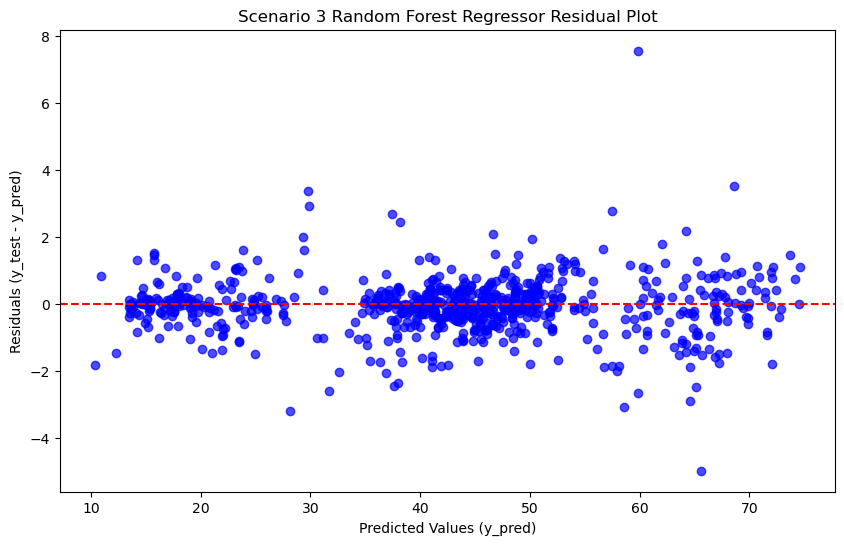

In [49]:
plot_residuals(y_test_s3, test_preds_rf_s3, 'Scenario 3 Random Forest Regressor')

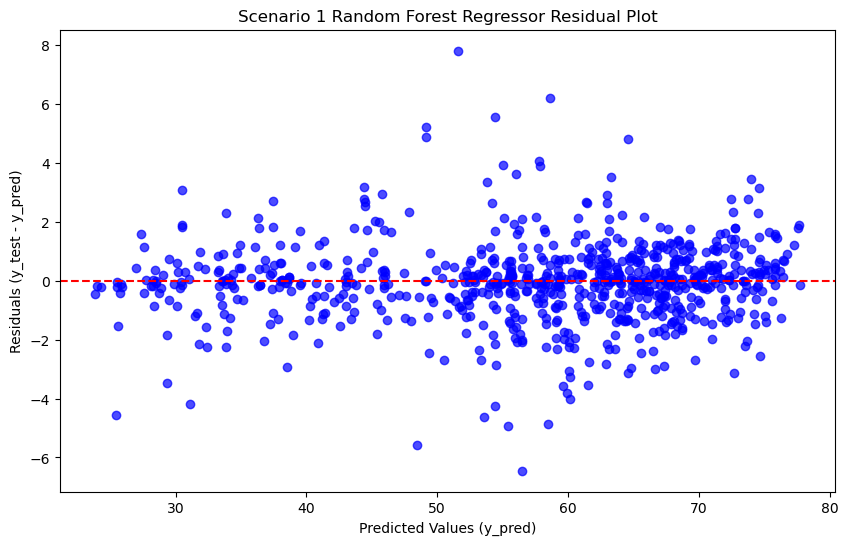

In [54]:
plot_residuals(y_test_s1, y_pred_rf_s1, 'Scenario 1 Random Forest Regressor')

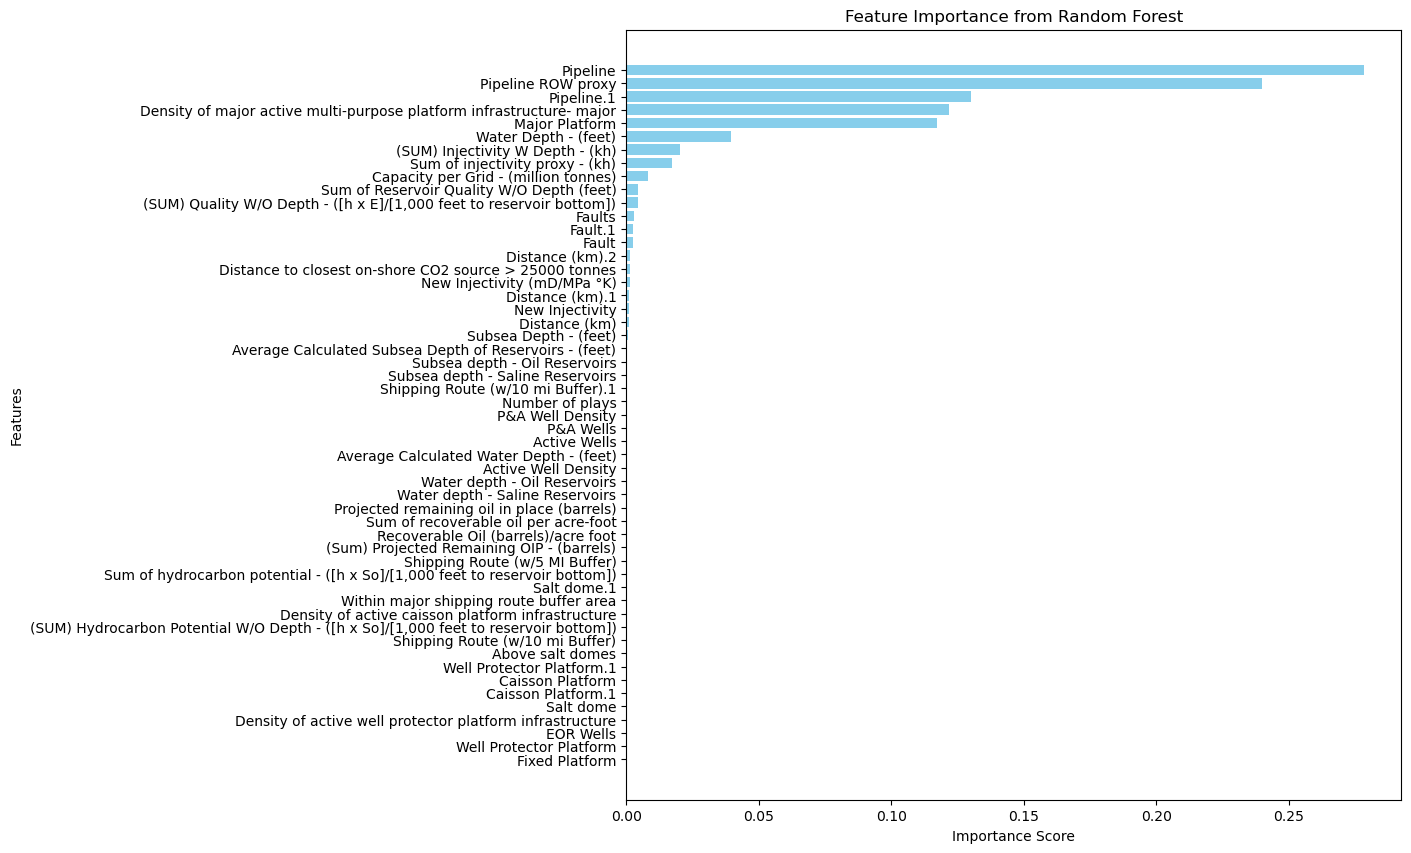

In [68]:
feature_importance_plot(rf_s3, X_train_s3)

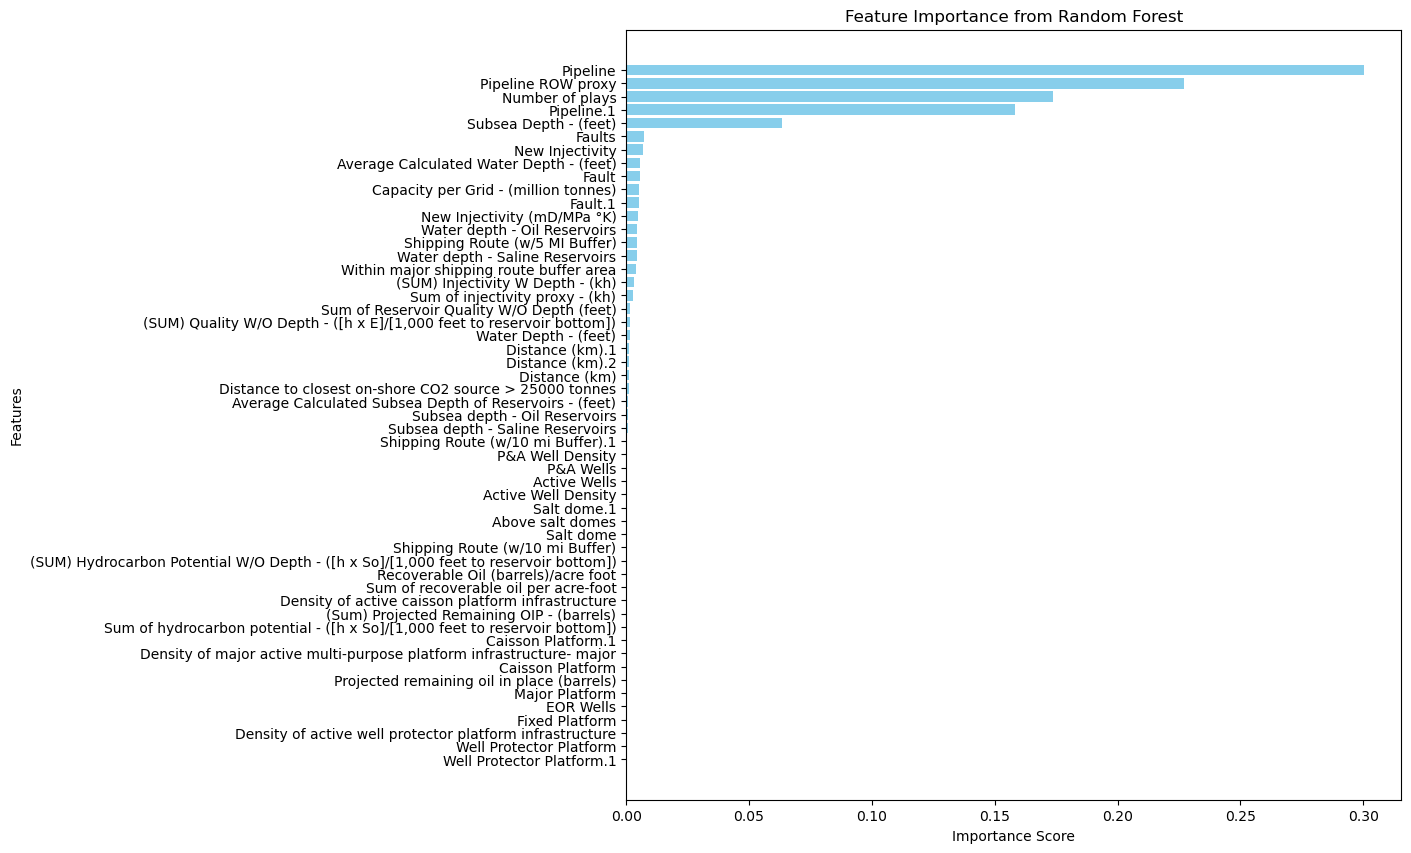

In [69]:
feature_importance_plot(rf_s1, X_train_s1)

## I decided to redo PCA bc I hate myself (don't have to explain lin alg anymore)

In [57]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(wendt_standardized)
wendt_2d_2= pca.transform(wendt_standardized)[:, :2]

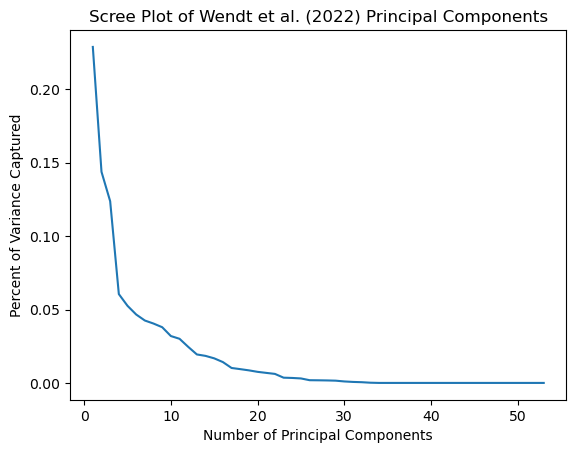

In [60]:
x= np.arange(1, 54)
y = pca.explained_variance_ratio_
plt.plot(x, y)
plt.xlabel('Number of Principal Components')
plt.ylabel('Percent of Variance Captured')
plt.title('Scree Plot of Wendt et al. (2022) Principal Components')
plt.show()

## Neural Network Model

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

nn = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(
        hidden_layer_sizes=(100,),
        max_iter=1000,
        random_state=22)) ])

nn.fit(X_train_s1, y_train_s1)
y_pred_nn_s1 = nn.predict(X_test_s1)

print('MSE:', mean_squared_error(y_test_s1, y_pred_nn_s1))

MSE: 6.403207476521271


In [52]:
cv = KFold(n_splits=5, shuffle=True, random_state=22)

pipe = Pipeline([
    ('scaler', StandardScaler()), #standardize features for neural net
    ('mlp', MLPRegressor(
        random_state=22,
        max_iter=2000,
        early_stopping=True,
        n_iter_no_change=20 )) ])

hyperparameters = {
    'mlp__hidden_layer_sizes': [(30,), (50,)],  
    'mlp__alpha': [0.01, 0.1],                   
    'mlp__learning_rate_init': [0.001] }

nn_s3 = GridSearchCV(
    estimator=pipe,
    param_grid=hyperparameters,
    scoring={'mse': 'neg_mean_squared_error', 'r2': 'r2'},
    refit='mse',
    cv=cv,
    return_train_score=True )

nn_s3.fit(X_train_s3, y_train_s3)
test_preds_nn_s3 = nn_s3.predict(X_test_s3)
train_preds_nn_s3 = nn_s3.predict(X_train_s3)

print('Train MSE:', mean_squared_error(y_train_s3, train_preds_nn_s3))
print('Mean Validation MSE:', -nn_s3.cv_results_['mean_test_mse'][nn_s3.best_index_])
print('Test MSE:', mean_squared_error(y_test_s3, test_preds_nn_s3))

print('Train R2:', r2_score(y_train_s3, train_preds_nn_s3))
print('Mean Validation R2:', nn_s3.cv_results_['mean_test_r2'][nn_s3.best_index_])
print('Test R2:', r2_score(y_test_s3, test_preds_nn_s3))

Train MSE: 0.49136070862761033
Mean Validation MSE: 3.5817045915273695
Test MSE: 3.863046013178385
Train R2: 0.9979071614582038
Mean Validation R2: 0.9845685192234773
Test R2: 0.9833948916724137


### Scenario 1

In [53]:
cv = KFold(n_splits=5, shuffle=True, random_state=22)

pipe = Pipeline([
    ('scaler', StandardScaler()), #standardize features for neural net
    ('mlp', MLPRegressor(
        random_state=22,
        max_iter=2000,
        early_stopping=True,
        n_iter_no_change=20 )) ])

hyperparameters = {
    'mlp__hidden_layer_sizes': [(30,), (50,)],  
    'mlp__alpha': [0.01, 0.1],                   
    'mlp__learning_rate_init': [0.001] }

nn_s1 = GridSearchCV(
    estimator=pipe,
    param_grid=hyperparameters,
    scoring={'mse': 'neg_mean_squared_error', 'r2': 'r2'},
    refit='mse',
    cv=cv,
    return_train_score=True )

nn_s1.fit(X_train_s1, y_train_s1)
test_preds_nn_s1 = nn_s1.predict(X_test_s1)
train_preds_nn_s1 = nn_s1.predict(X_train_s1)

print('Train MSE:', mean_squared_error(y_train_s1, train_preds_nn_s1))
print('Mean Validation MSE:', -nn_s1.cv_results_['mean_test_mse'][nn_s1.best_index_])
print('Test MSE:', mean_squared_error(y_test_s1, test_preds_nn_s1))

print('Train R2:', r2_score(y_train_s1, train_preds_nn_s1))
print('Mean Validation R2:', nn_s1.cv_results_['mean_test_r2'][nn_s1.best_index_])
print('Test R2:', r2_score(y_test_s1, test_preds_nn_s1))

Train MSE: 0.687000027832318
Mean Validation MSE: 7.607800327163014
Test MSE: 4.990451799194495
Train R2: 0.996157009128895
Mean Validation R2: 0.9555912780002119
Test R2: 0.9720713623327023


## Gradient Boosting Regressor
### Scenario 3

In [57]:
cv = KFold(n_splits=5, shuffle=True, random_state=22)

hyperparameters = {
    'n_estimators': [200, 400],
    'max_depth': [3, 5],              
    'min_samples_leaf': [1, 3],
    'max_features': ['sqrt', 0.5] }

gb_s3 = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=22),
    param_grid=hyperparameters,
    scoring={'mse': 'neg_mean_squared_error', 'r2': 'r2'},
    refit='mse',
    cv=cv,
    return_train_score=True)

gb_s3.fit(X_train_s3, y_train_s3)
test_preds_gb_s3 = gb_s3.predict(X_test_s3)
train_preds_gb_s3 = gb_s3.predict(X_train_s3)

print('Train MSE:', mean_squared_error(y_train_s3, train_preds_gb_s3))
print('Mean Validation MSE:', -gb_s3.cv_results_['mean_test_mse'][gb_s3.best_index_])
print('Test MSE:', mean_squared_error(y_test_s3, test_preds_gb_s3))
print('Train R2:', r2_score(y_train_s3, train_preds_gb_s3))
print('Mean Validation R2:', gb_s3.cv_results_['mean_test_r2'][gb_s3.best_index_])
print('Test R2:', r2_score(y_test_s3, test_preds_gb_s3))

Train MSE: 0.07347812519312513
Mean Validation MSE: 0.4017424943494398
Test MSE: 0.40838824244122923
Train R2: 0.9996870367335382
Mean Validation R2: 0.9982765370019004
Test R2: 0.9982445637503888


### Scenario 1

In [58]:
gb_s1 = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=22),
    param_grid=hyperparameters,
    scoring={'mse': 'neg_mean_squared_error', 'r2': 'r2'},
    refit='mse',
    cv=cv,
    return_train_score=True)

gb_s1.fit(X_train_s1, y_train_s1)
test_preds_gb_s1 = gb_s1.predict(X_test_s1)
train_preds_gb_s1 = gb_s1.predict(X_train_s1)

print('Train MSE:', mean_squared_error(y_train_s1, train_preds_gb_s1))
print('Mean Validation MSE:', -gb_s1.cv_results_['mean_test_mse'][gb_s1.best_index_])
print('Test MSE:', mean_squared_error(y_test_s1, test_preds_gb_s1))
print('Train R2:', r2_score(y_train_s1, train_preds_gb_s1))
print('Mean Validation R2:', gb_s1.cv_results_['mean_test_r2'][gb_s1.best_index_])
print('Test R2:', r2_score(y_test_s1, test_preds_gb_s1))

Train MSE: 0.1362288914948696
Mean Validation MSE: 0.54531115569403
Test MSE: 0.5963812216857521
Train R2: 0.9992379528891033
Mean Validation R2: 0.9968944807406002
Test R2: 0.9966624033810465


## Lasso Regression
### Scenario 1

In [65]:
pipe = Pipeline([
    ('scaler', StandardScaler()),  # scaling important for Lasso
    ('lasso', Lasso(random_state=22, max_iter=10000)) ])

hyperparameters = {
    'lasso__alpha': [0.001, 0.01, 0.1, 1.0] }

lasso_s1 = GridSearchCV(
    estimator=pipe,
    param_grid=hyperparameters,
    scoring={'mse': 'neg_mean_squared_error', 'r2': 'r2'},
    refit='mse',
    cv=cv,
    return_train_score=True)

lasso_s1.fit(X_train_s1, y_train_s1)
test_preds_lasso_s1 = lasso_cv.predict(X_test_s1)
train_preds_lasso_s1 = lasso_cv.predict(X_train_s1)

print('Train MSE:', mean_squared_error(y_train_s1, train_preds_lasso_s1))
print('Mean Validation MSE:', -lasso_s1.cv_results_['mean_test_mse'][lasso_s1.best_index_])
print('Test MSE:', mean_squared_error(y_test_s1, test_preds_lasso_s1))
print('Train R2:', r2_score(y_train_s1, train_preds_lasso_s1))
print('Mean Validation R2:', lasso_s1.cv_results_['mean_test_r2'][lasso_s1.best_index_])
print('Test R2:', r2_score(y_test_s1, test_preds_lasso_s1))

Train MSE: 2.1414024648817982e-05
Mean Validation MSE: 2.188421055252175e-05
Test MSE: 2.21303467961548e-05
Train R2: 0.9999998802126668
Mean Validation R2: 0.9999998773105869
Test R2: 0.9999998761494026


### Scenario 3

In [62]:
pipe = Pipeline([
    ('scaler', StandardScaler()),  # scaling important for Lasso
    ('lasso', Lasso(random_state=22, max_iter=10000)) ])

hyperparameters = {
    'lasso__alpha': [0.001, 0.01, 0.1, 1.0] }

lasso_s3 = GridSearchCV(
    estimator=pipe,
    param_grid=hyperparameters,
    scoring={'mse': 'neg_mean_squared_error', 'r2': 'r2'},
    refit='mse',
    cv=cv,
    return_train_score=True)

lasso_s3.fit(X_train_s3, y_train_s3)
test_preds_lasso_s3 = lasso_s3.predict(X_test_s3)
train_preds_lasso_s3 = lasso_s3.predict(X_train_s3)

print('Train MSE:', mean_squared_error(y_train_s3, train_preds_lasso_s3))
print('Mean Validation MSE:', -lasso_s3.cv_results_['mean_test_mse'][lasso_s3.best_index_])
print('Test MSE:', mean_squared_error(y_test_s3, test_preds_lasso_s3))
print('Train R2:', r2_score(y_train_s3, train_preds_lasso_s3))
print('Mean Validation R2:', lasso_s3.cv_results_['mean_test_r2'][lasso_s3.best_index_])
print('Test R2:', r2_score(y_test_s3, test_preds_lasso_s3))

Train MSE: 0.00019842078357486446
Mean Validation MSE: 0.00034135362558520866
Test MSE: 1.4419735299413825e-05
Train R2: 0.9999991548720603
Mean Validation R2: 0.9999984509016585
Test R2: 0.9999999380174955


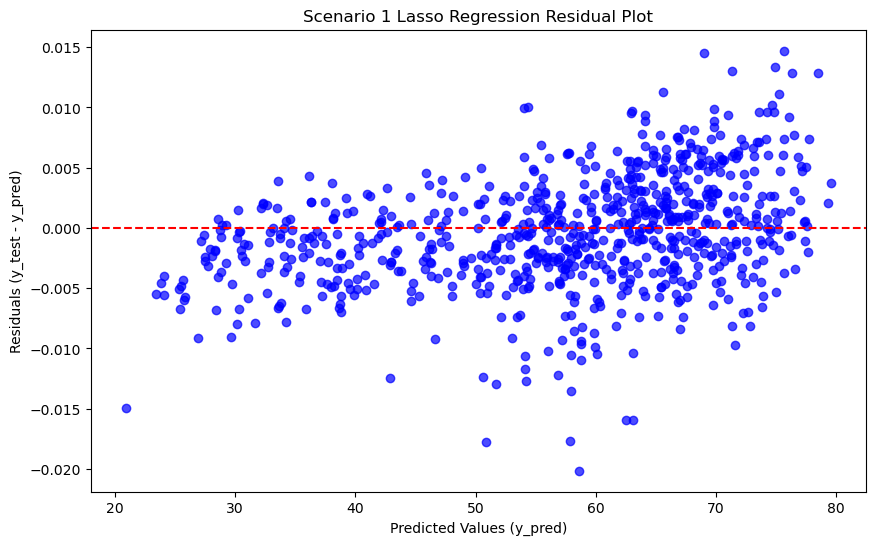

In [60]:
plot_residuals(y_test_s1, test_preds_lasso_s1, 'Scenario 1 Lasso Regression')

In [138]:
from sklearn import ensemble
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
mse

0.9204881422162673

In [139]:
reg = ensemble.GradientBoostingRegressor()
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
mse

0.6954876692177141

In [144]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
regr.fit(X_train, y_train)
mse = mean_squared_error(y_test, regr.predict(X_test))
mse

16.99678854703611

# Combined plots for thesis

## PCA Wendt

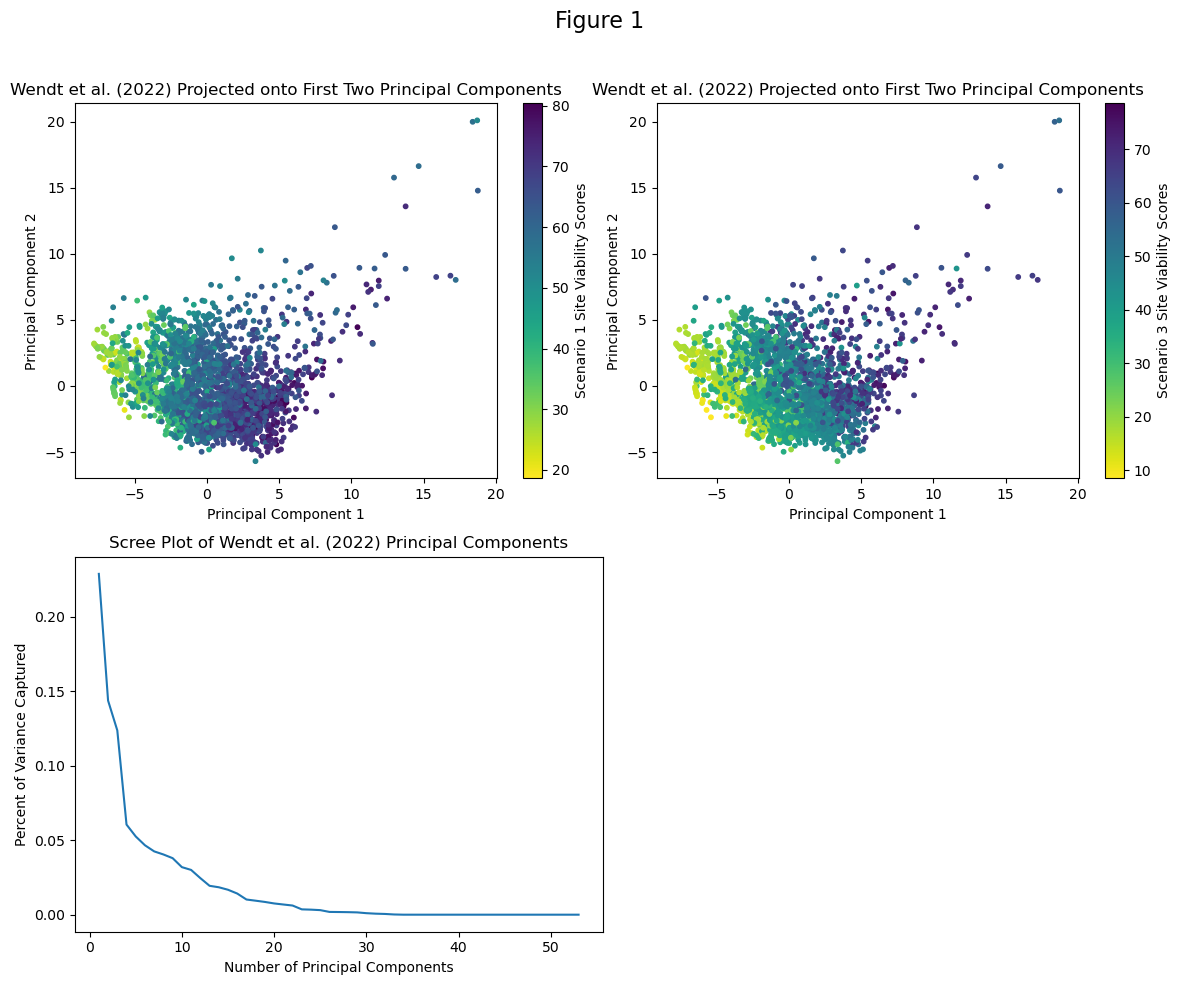

In [22]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# --- Scenario 1 (top left) ---
sc1 = axes[0, 0].scatter(
    wendt_2d[:, 0],
    wendt_2d[:, 1],
    c=wendt['S1'],
    s=10,
    cmap='viridis_r'
)
axes[0, 0].set_title("Wendt et al. (2022) Projected onto First Two Principal Components")
axes[0, 0].set_xlabel("Principal Component 1")
axes[0, 0].set_ylabel("Principal Component 2")
cbar1 = fig.colorbar(sc1, ax=axes[0, 0])
cbar1.set_label("Scenario 1 Site Viability Scores")

# --- Scenario 3 (top right) ---
sc2 = axes[0, 1].scatter(
    wendt_2d[:, 0],
    wendt_2d[:, 1],
    c=wendt['S3'],
    s=10,
    cmap='viridis_r'
)
axes[0, 1].set_title("Wendt et al. (2022) Projected onto First Two Principal Components")
axes[0, 1].set_xlabel("Principal Component 1")
axes[0, 1].set_ylabel("Principal Component 2")
cbar2 = fig.colorbar(sc2, ax=axes[0, 1])
cbar2.set_label("Scenario 3 Site Viability Scores")

# --- Scree Plot (bottom left) ---
x = np.arange(1, 54)
y = pca.explained_variance_ratio_

axes[1, 0].plot(x, y)
axes[1, 0].set_xlabel('Number of Principal Components')
axes[1, 0].set_ylabel('Percent of Variance Captured')
axes[1, 0].set_title('Scree Plot of Wendt et al. (2022) Principal Components')

# --- Empty bottom-right ---
axes[1, 1].axis('off')

plt.tight_layout()

fig.suptitle("Figure 1", fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 

# Save as high-resolution PNG
plt.savefig("Figure_1.png", dpi=300, bbox_inches='tight')

plt.show()

## Residual Plot for Wendt

In [70]:
def plot_residuals(y_true, y_pred, model_name, ax=None):
    if ax is None:
        ax = plt.gca()  # current axes
    resid = y_true - y_pred
    ax.scatter(y_pred, resid, alpha=0.6)
    ax.axhline(0, color='black', linestyle='--')
    ax.set_title(model_name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Residuals')

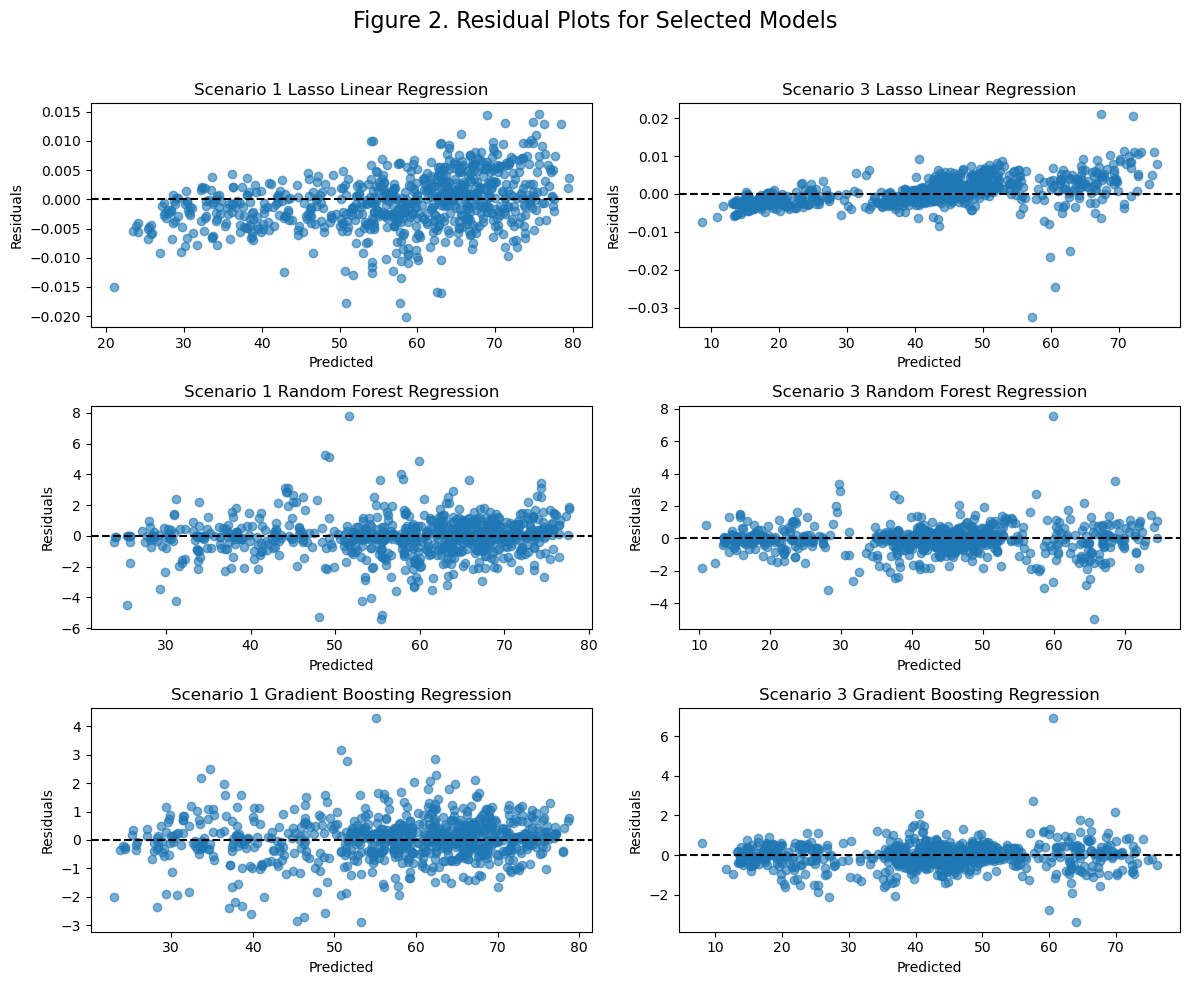

In [73]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

plot_residuals(y_test_s1, test_preds_lasso_s1, 'Scenario 1 Lasso Linear Regression', ax=axes[0,0])
plot_residuals(y_test_s3, test_preds_lasso_s3, 'Scenario 3 Lasso Linear Regression', ax=axes[0,1])
plot_residuals(y_test_s1, test_preds_rf_s1, 'Scenario 1 Random Forest Regression', ax=axes[1,0])
plot_residuals(y_test_s3, test_preds_rf_s3, 'Scenario 3 Random Forest Regression', ax=axes[1,1])
plot_residuals(y_test_s1, test_preds_gb_s1, 'Scenario 1 Gradient Boosting Regression', ax=axes[2,0])
plot_residuals(y_test_s3, test_preds_gb_s3, 'Scenario 3 Gradient Boosting Regression', ax=axes[2,1])

fig.suptitle('Figure 2. Residual Plots for Selected Models', fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.savefig("Figure_2.png", dpi=300, bbox_inches='tight')

plt.show()
